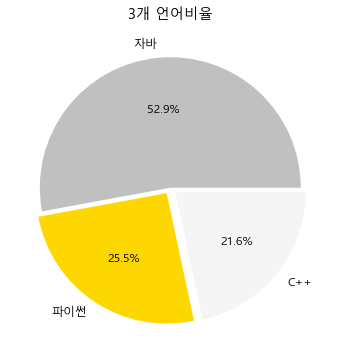

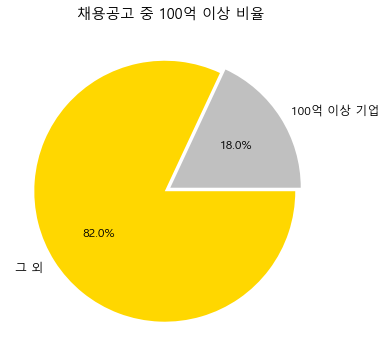

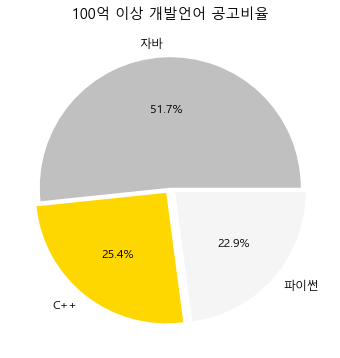

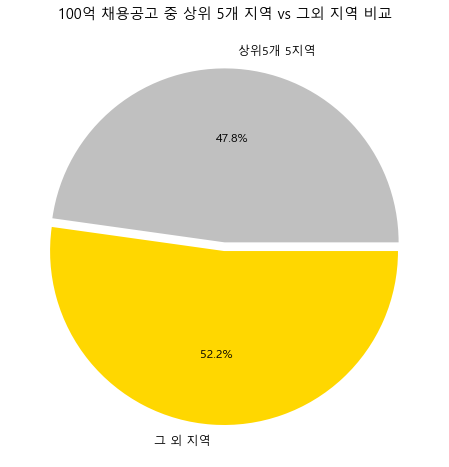

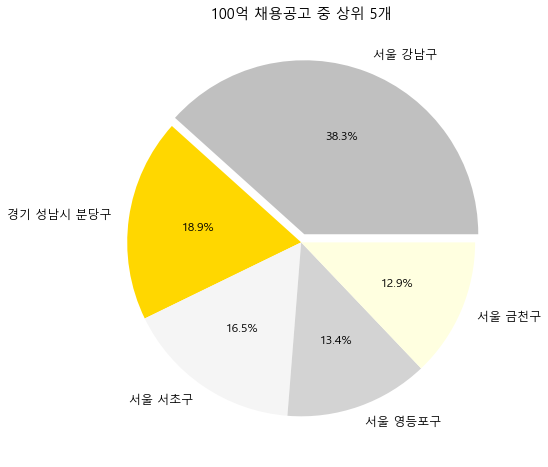

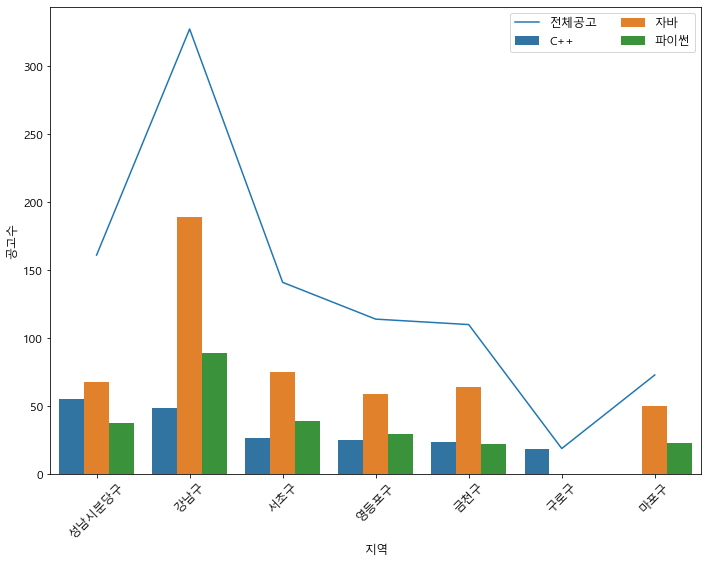

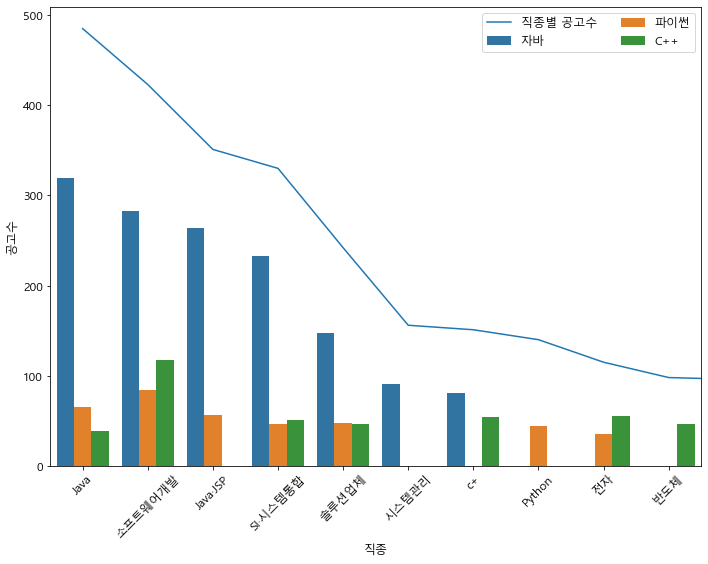

In [18]:
########################## 매출액 100억이상 분석 ############################### (효제)

import pandas as pd
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# 경고 무시
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.set_option('mode.chained_assignment',  None)

#  한글글꼴로 변경
plt.rcParams['font.size'] = 12.0
plt.rcParams['font.family'] = 'Malgun Gothic'

# plt 컬러지정
colors = ['silver', 'gold', 'whitesmoke', 'lightgray','lightyellow']

# 맵 데이터 인식
geo_path = './HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path, encoding='utf-8'))

############################################################기본설정 완료

# 억단위 금액만 추출하여 컬럼 추가
def cash_comparison(df, column):
    lst = []
    for i in df.machul.str.split('억'): # 억단위로 분리
        if '만원' not in i[0] and '매출' not in i[0]: # 억 단위만 숫자 추가
            lst.append(int(i[0].replace(',','')))
        else: # 그 외 데이터 값 저장
            lst.append('X')

    lst_df = pd.DataFrame(lst, columns={f'{column}'})
    if f'{column}' in df.index:
        del df[f'{column}']
        df = pd.concat([df, lst_df], axis=1)
        return df

    else:
        df = pd.concat([df, lst_df], axis=1)
        return df

# ??구, ??시 데이터 추출
def change(data):
    if len(data)==2: 
        return data[1]
    elif len(data)==1: # 세종특별자치시
        return data[0]
    else: 
        return ''.join(data[1:])
        
# apply용 함수
def get_top(group,num = 6):
    return group.sort_values(by='title', ascending=False)[:num] 

############################################################ 데이터 추출 필요함수

# 각 언어별 데이터프레임 생성
df_p = pd.read_csv('./파이썬_saramin_copy.csv')  
df_j = pd.read_csv('./자바_saramin_copy.csv')
df_c = pd.read_csv('./C++_saramin_copy.csv')

# 전체데이터 병합
# 파이썬 2518 / 자바 5232 / C언어 2140 / all 9890 건
df = pd.concat([df_p,df_c, df_j], ignore_index=True)

# 필요 컬럼으로 데이터프레임 생성 (전체)
df_a = df[['title','station','carrer', 'work','machul', 'juso', 'search_key']] 

############################################################  기본 데이터 프레임 생성완료

# 한국외 주소가 있는 경우
foreign_index = df_a.loc[df_a.station.str.contains('경력') |
                        df_a.station.str.contains('아시아') | 
                        df_a.station.str.contains('일본') |
                        df_a.station.str.contains('미국')|
                        df_a.station.str.contains('중국')|
                        df_a.station.str.contains('신입')|
                        df_a.station.str.contains('전체')].index

# 한국외 채용주소는 회사주소로 변경
# 주소없는 회사는 11곳
df_a.loc[(df_a.station.str.contains('경력') |
            df_a.station.str.contains('아시아') | 
            df_a.station.str.contains('일본') |
            df_a.station.str.contains('미국')|
            df_a.station.str.contains('중국')|
            df_a.station.str.contains('신입')|
            df_a.station.str.contains('전체')),
            'station'] = df_a.loc[foreign_index].juso

# 직종이 없는곳 처리
df_a.work.loc[df_a.work.isnull()] = '직종없음' 

############################################################ 예외처리

# 억단위 금액 컬럼 추가
# cash = input('추가할 컬럼명: ')
cash = 'cash'
df_a = cash_comparison(df_a, cash) 

#geo 파일 sggnm 매핑
df_a['si_gu'] = (df_a.station.str.split(' ')).apply(change)



############################################################ 데이터컬럼 추가


try :
    # 채용공고 언어비율
    df_a_dev = df_a.groupby(['search_key']).count().sort_values(by='title', ascending=False)

    # won억이상 회사 추출
    won = 100
    # won = int(input('몇억이상?'))
    df_a_won= df_a.iloc[df_a.query('cash != "X"').query(f'cash >= {won}').index] 

    # won억이상 회사에서 뽑는 비율 추출
    df_a_won_dev = df_a_won.groupby(['search_key']).count()\
                    .sort_values(by='title', ascending=False)


    # 지역별 won억 이상 회사 채용공고수
    df_a_won_sort = df_a_won.groupby(['si_gu', 'station'],as_index=False)\
                    .count().sort_values(by='title', ascending=False)


    # 언어별 채용공고수 상위 ?개
    
    df_count_search_key =df_a_won.groupby(['si_gu', 'station','search_key'],\
                        as_index=True).count()

    # 언어별 상위?개 지역
    # num = int(input('언어별 상위 몇개지역까지 보시겠습니까?'))
    # df_count_search_key_apply = df_count_search_key.reset_index()\
    #                           .groupby('search_key').apply(get_top, num=num) 

    df_count_search_key_apply = df_count_search_key.reset_index()\
                                .groupby('search_key').apply(get_top)

    df_count_search_key_apply_sort = df_count_search_key_apply.filter(['station', 'title']).reset_index()\
        .groupby('station').sum().reindex\
            (['경기 성남시 분당구',
            '서울 강남구',
            '서울 서초구',
            '서울 영등포구',
            '서울 금천구',
            '서울 구로구',
            '서울 마포구'], axis='index') # 하드코딩 ㅠ


    # 직종 분석 데이터프레임 추출 쿼리
    # 직종데이터 분리
    lst = []
    for i in df_a_won.work.str.split(','): 
        if type(i) != float: # 없는곳 예외처리
            lst += i

    #직종별 공고수 저장        
    work_lst = [] 
    for i in set(lst):
        work_lst.append([i,lst.count(i)]) 

    # 직종별 공고수, 직종명 데이터프레임
    
    work_df = pd.DataFrame(work_lst,columns={'w', 'c'})\
        .sort_values(by='c', ascending=False, ignore_index=True)
    
    # 직종명 저장
    if type(work_df['w'][0]) ==str:
        five_work = work_df['w'][:]
    else:
        five_work = work_df['c'][:]

    work_2_lst = [] 
    for i in five_work:
        if '++' in str(i): 
            i ='c+'
        frame = df_a_won[df_a_won.work.str.contains(i)]
        frame['work_2'] = i
        work_2_lst.append(frame)
        
    work_2_df = pd.concat(work_2_lst).sort_values(by='title', ascending=False).reset_index()
    del work_2_df['index']
    work_2_total=work_2_df.groupby('work_2').count().sort_values(by='title', ascending=False)
    work_2_search=work_2_df.groupby(['work_2', 'search_key'])\
            .count().sort_values(by='title', ascending=False).reset_index()

    # 언어별 상위 7개 직종 병합
    work_2_3search = pd.concat([work_2_search[work_2_search.search_key=='자바'][:7]\
                ,work_2_search[work_2_search.search_key=='파이썬'][:7]\
                ,work_2_search[work_2_search.search_key=='C++'][:7]])
except TypeError as e:
    print(e,'\n','직종 분석중 오류가 발생하였습니다. 다시 시도하세요.')
except ValueError as e:
    print(e, '\n','데이터 정리 중 오류가 발생하였습니다. 다시 시도하세요.')


############################################# 분석별 데이터프레임 영역


try:
    
    # 전체 채용공고 중 3개 언어비율
    
    plt.figure(figsize=(10,6))
    plt.pie(x =df_a_dev.title, 
            labels = df_a_dev.index,
            autopct='%.1f%%',
            explode=(0, 0.05, 0.05),
            colors= colors[:3]
            );
    plt.title('3개 언어비율')
    plt.show()

    # 전체 채용공고 중 won억 이상 비율
    
    plt.figure(figsize=(10,6))
    plt.pie(x = [len(df_a_won),len(df_a)-len(df_a_won)], 
            labels = [f'{won}억 이상 기업', '그 외'],
            autopct='%.1f%%',
            explode=(0, 0.05),
            colors= colors[:3]
            );
    plt.title(f'채용공고 중 {won}억 이상 비율')
    plt.show()

    # won억 이상 개발언어 공고
    plt.figure(figsize=(10,6))
    plt.pie(x =df_a_won_dev.title, 
            labels = df_a_won_dev.index,
            autopct='%.1f%%',
            explode=(0, 0.05, 0.05),
            colors= colors[:3]
            );
    plt.title(f'{won}억 이상 개발언어 공고비율')
    plt.show()

    # won억 채용공고 중 상위 5개 vs 그외 지역 비교
    plt.figure(figsize=(10,8))
    plt.pie(x = [df_a_won_sort.title[:5].sum(),df_a_won_sort.title[5:].sum()], 
            labels = ['상위5개 5지역', '그 외 지역'],
            autopct='%.1f%%',
            explode=(0, 0.05),
            colors= colors[:2]
            );
    plt.title(f'{won}억 채용공고 중 상위 5개 지역 vs 그외 지역 비교')
    plt.show()

    # won억 매출기업 중 상위 다섯개 비율
    plt.figure(figsize=(10,8))
    plt.pie(df_a_won_sort.title[:5], 
            labels=df_a_won_sort.station[:5],
            autopct='%.1f%%',
            explode=(0.05, 0,0,0,0),
            colors= colors
            );
    plt.title(f'{won}억 채용공고 중 상위 5개')
    plt.show()

    # 언어별 상위 지역 그래프 표시
    plt.figure(figsize=(10,8))
    plt.plot(df_count_search_key_apply_sort.index, df_count_search_key_apply_sort.title,label='전체공고')
    sns.barplot(x='si_gu', y='title', hue='search_key', data=df_count_search_key_apply)\
        .legend(loc='upper right', ncol=2)
    plt.xticks(rotation=45)
    plt.xlabel('지역')
    plt.ylabel('공고수')
    plt.tight_layout()
    plt.show()

    # 직종별 그래프
    plt.figure(figsize=(10,8))
    plt.plot(work_2_total.index[:11], work_2_total.title[:11], label='직종별 공고수')
    sns.barplot(x='work_2', y='title', hue='search_key', data=work_2_3search).legend(loc='upper right', ncol=2)
    plt.xlabel('직종')
    plt.ylabel('공고수')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except:
    print('분석 중 오류가 발생하였습니다. 다시 시도하세요')


############################################################ won억대 기업데이터분석


try:
    # 맵 기본위치
    station = folium.Map(location = [37.467022027079715, 127.04911397768764], zoom_start=11,tiles='cartodbpositron')
    # won원 이상 상위 5개
    station.choropleth(geo_path=geo_path, #지역 경계선
                    data=df_a_won_sort[:5], # 데이터
                    columns=[df_a_won_sort[:5].si_gu, 'title'],
                    geo_data=geo_str,
                    key_on ='feature.properties.sggnm', 
                    fill_color='Accent', 
                    line_color='black',
                    line_weight=0,
                    line_opacity=0,
                    legend_name='상위 5개 지역 채용공고수',
                    nan_fill_color='white')

    # 상위 5개 마커 / 경도 크롤링 가능한지 확인
    five_area = \
    [[[37.52999752751669, 126.89574556556897], '영등포구'],
    [[37.38625596977615, 127.11868043782715], '분당구'],
    [[37.48446673059676, 127.03256663058319], '서초구'],
    [[37.456868879955685, 126.89542195590025],'금천구'],
    [[37.51930083849949, 127.04761269824259], '강남구']]

    for i in five_area:    
        folium.Marker(i[0], popup=f'{i[1]}',
        icon=folium.Icon(icon='star', color='red',prefix='fa')).add_to(station)
        
    # won원 이상 상위 5개 외
    station.choropleth(geo_path=geo_path, #지역 경계선
                        data=df_a_won_sort[5:], # 데이터
                        columns=[df_a_won_sort[5:].si_gu, 'title'],
                        geo_data=geo_str,
                        key_on ='feature.properties.sggnm', 
                        fill_color='RdPu', 
                        line_color='black',
                        line_weight=0,
                        line_opacity=0,
                        legend_name='지역별 채용공고수',
                        nan_fill_color='white')

    station.save('station.html')
    
except:
    print('지도를 만드는 도중 오류가 발생하였습니다. 다시 시도하세요')


############################################################ geo 데이터 표현

